In [1]:
from google.colab import drive
drive.mount('/content/gdrive') # 그냥 drive면 수정
# (선택) 꼬였을 때 강제 재마운트
# drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [2]:
!pip install -q ultralytics gdown wandb pyyaml opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.8 MB/s eta 0:00:00


In [ ]:
# !mkdir -p /content/gdrive   ( 빈 폴더(gdrive) 생성)

In [3]:
# =========================
# Run Context & Path Setup
# =========================
from pathlib import Path
from datetime import datetime
import shutil

# 1) 날짜
date_tag = datetime.now().strftime("%Y%m%d")

# 2) 실험 이름 (🔥 여기만 바꾸면 됨)
run_name = f"{date_tag}_y8m_640_b16_e40_A4_S3_AIHub_P11"

# 3) 프로젝트 루트
ROOT_DIR = Path("/content/gdrive/MyDrive/AI-06_5team-Object-Detection")

# 4) 데이터 경로
DATA_DIR = ROOT_DIR / "data"
YOLO_BASE_PATH = Path("/content/yolo_dataset") # ✅ 로컬로 변경 (초고속)

TRAIN_IMAGE_DIR = DATA_DIR / "train_images"
TEST_DIR  = DATA_DIR / "test_images"

# 5) YOLO runs 경로
RUNS_DIR = ROOT_DIR / "notebooks" / "yolo_runs"
RUN_DIR = RUNS_DIR / run_name
RUN_DIR.mkdir(parents=True, exist_ok=True)

# 6) run 전용 data.yaml 위치
DATA_YAML_PATH = RUN_DIR / "data.yaml"

print("ROOT_DIR:", ROOT_DIR)
print("DATA_DIR:", DATA_DIR)
print("샘플 이미지 수:", len(list(TRAIN_IMAGE_DIR.iterdir())))


ROOT_DIR: /content/gdrive/MyDrive/AI-06_5team-Object-Detection
DATA_DIR: /content/gdrive/MyDrive/AI-06_5team-Object-Detection/data
샘플 이미지 수: 651


In [ ]:
# =========================
# 데이터셋 생성 시작 직전
# =========================

# (선택) YOLO_BASE_PATH를 통째로 새로 만들고 싶을 때만
# ⚠️ 이 줄 아래부터 데이터 다시 만들어짐
# shutil.rmtree(YOLO_BASE_PATH, ignore_errors=True)
# YOLO_BASE_PATH.mkdir(parents=True, exist_ok=True)

# ↓↓↓ 여기부터 FINAL_DICT / make_split / data.yaml 생성 ↓↓↓


In [6]:
import json, shutil
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
import yaml
from collections import Counter
import random

# --- 경로 ---
FIXED_DICT_PATH = DATA_DIR / "FIXED_DICT.json"
ERR_TXT_PATH = DATA_DIR / "err_image_paths.txt"

# 1) load fixed dict
with open(FIXED_DICT_PATH, "r", encoding="utf-8") as f:
    FIXED_DICT = json.load(f)

# 2) error images (옵션)
err_images = set()
if ERR_TXT_PATH.exists():
    with open(ERR_TXT_PATH, "r", encoding="utf-8") as f:
        err_images = {line.strip() for line in f if line.strip()}

# 3) FINAL_DICT
FINAL_DICT = {}
missing = 0

for img_name, ann_list in FIXED_DICT.items():
    img_path = TRAIN_IMAGE_DIR / img_name
    if not img_path.exists():
        missing += 1
        continue

    FINAL_DICT[str(img_path)] = [
        {"bbox": ann["bbox"], "label": str(ann["label"])}
        for ann in ann_list
        if isinstance(ann, dict) and "bbox" in ann and "label" in ann
    ]

print(f"✅ FINAL_DICT: {len(FINAL_DICT)}개 (missing skipped: {missing})")
if not FINAL_DICT:
    raise ValueError("FINAL_DICT가 비었습니다.")


✅ FINAL_DICT: 651개 (missing skipped: 0)


In [7]:
# =========================
# class mapping
# =========================
labels = sorted(
    {a["label"] for anns in FINAL_DICT.values() for a in anns},
    key=lambda x: int(x)
)

label_to_idx = {l: i for i, l in enumerate(labels)}
idx_to_label = {i: l for l, i in label_to_idx.items()}
idx_to_category_id = {i: int(idx_to_label[i]) for i in idx_to_label}

print("✅ 클래스 수(nc):", len(label_to_idx))

# =========================
# 1) 라벨 빈도 계산
# =========================
all_labels = []
for anns in FINAL_DICT.values():
    for a in anns:
        all_labels.append(a["label"])
label_counts = Counter(all_labels)

# =========================
# 2) 이미지별 대표(희귀) 라벨로 stratify
# =========================
image_paths = list(FINAL_DICT.keys())
stratify_labels = []

for p in image_paths:
    anns = FINAL_DICT[p]
    rare = min(label_counts[a["label"]] for a in anns)
    rare_label = min(
        anns, key=lambda a: label_counts[a["label"]]
    )["label"]
    stratify_labels.append(label_to_idx[rare_label])

train_imgs, val_imgs = train_test_split(
    image_paths,
    test_size=0.2,
    random_state=42,
    stratify=stratify_labels
)

print("✅ split 완료:", len(train_imgs), len(val_imgs))

# =========================
# 3) 🔥 오버샘플링 (불균형 핵심)
# =========================
def image_rarity_score(img_path):
    anns = FINAL_DICT[img_path]
    return min(label_counts[a["label"]] for a in anns)

oversampled_train = []
for p in train_imgs:
    r = image_rarity_score(p)
    if r <= 2:
        k = 8
    elif r <= 5:
        k = 5
    elif r <= 10:
        k = 3
    else:
        k = 1
    oversampled_train.extend([p] * k)

random.shuffle(oversampled_train)

print("🔥 train 원본:", len(train_imgs))
print("🔥 train 오버샘플:", len(oversampled_train))


✅ 클래스 수(nc): 74
✅ split 완료: 520 131
🔥 train 원본: 520
🔥 train 오버샘플: 608


In [8]:
# =========================
# YOLO folder structure
# =========================
for p in [
    YOLO_BASE_PATH / "images/train",
    YOLO_BASE_PATH / "images/val",
    YOLO_BASE_PATH / "labels/train",
    YOLO_BASE_PATH / "labels/val",
]:
    p.mkdir(parents=True, exist_ok=True)

def xywh_to_yolo(bbox, w, h):
    x, y, bw, bh = bbox
    return [(x + bw/2)/w, (y + bh/2)/h, bw/w, bh/h]

def make_split(imgs, split):
    img_out = YOLO_BASE_PATH / f"images/{split}"
    lbl_out = YOLO_BASE_PATH / f"labels/{split}"

    for img_path in imgs:
        p = Path(img_path)
        with Image.open(p) as im:
            w, h = im.size

        shutil.copy(str(p), str(img_out / p.name))

        with open(lbl_out / f"{p.stem}.txt", "w") as f:
            for ann in FINAL_DICT[str(p)]:
                cid = label_to_idx[ann["label"]]
                bb = xywh_to_yolo(ann["bbox"], w, h)
                f.write(f"{cid} {' '.join(f'{v:.6f}' for v in bb)}\n")

make_split(oversampled_train, "train")
make_split(val_imgs, "val")

# =========================
# data.yaml
# =========================
data_yaml = {
    "path": str(YOLO_BASE_PATH.resolve()),
    "train": "images/train",
    "val": "images/val",
    "nc": len(label_to_idx),
    "names": {i: idx_to_category_id[i] for i in range(len(idx_to_category_id))},
}

with open(DATA_YAML_PATH, "w", encoding="utf-8") as f:
    yaml.safe_dump(data_yaml, f, allow_unicode=True, sort_keys=False)

print("🎉 YOLO dataset ready")
print("📄 data.yaml:", DATA_YAML_PATH)


🎉 YOLO dataset ready
📄 data.yaml: /content/gdrive/MyDrive/AI-06_5team-Object-Detection/notebooks/yolo_runs/20251218_y8m_640_b16_e40_A4_S3_AIHub_P11/data.yaml


In [9]:
print("✅ DATA_YAML_PATH:", DATA_YAML_PATH)
print("✅ YOLO_BASE_PATH exists:", YOLO_BASE_PATH.exists())
print("✅ train img count:", len(list((YOLO_BASE_PATH/'images/train').glob('*'))))
print("✅ val img count:", len(list((YOLO_BASE_PATH/'images/val').glob('*'))))
print("✅ train label count:", len(list((YOLO_BASE_PATH/'labels/train').glob('*.txt'))))


✅ DATA_YAML_PATH: /content/gdrive/MyDrive/AI-06_5team-Object-Detection/notebooks/yolo_runs/20251218_y8m_640_b16_e40_A4_S3_AIHub_P11/data.yaml
✅ YOLO_BASE_PATH exists: True
✅ train img count: 520
✅ val img count: 131
✅ train label count: 520


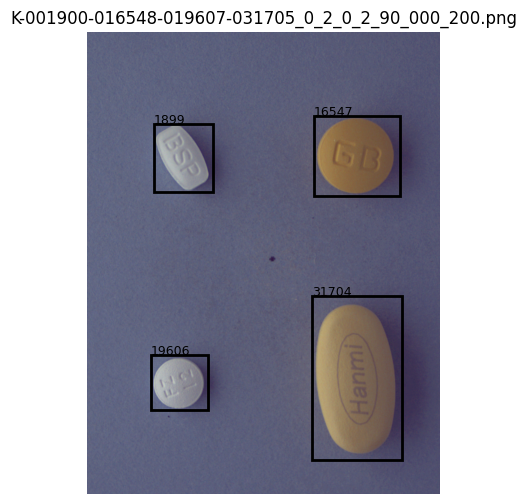

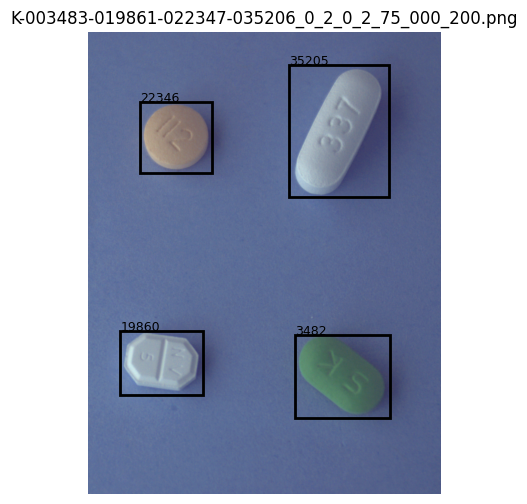

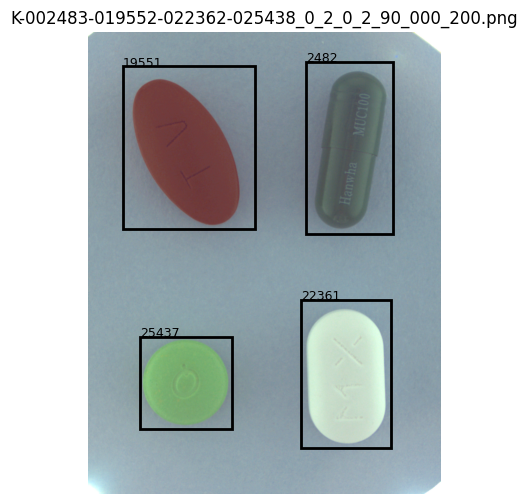

In [10]:
# (A) sanity check
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

sample_imgs = random.sample(list(FINAL_DICT.keys()), k=3)

for img_path in sample_imgs:
    p = Path(img_path)
    im = Image.open(p).convert("RGB")

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(im)

    for ann in FINAL_DICT[str(p)]:
        x, y, bw, bh = ann["bbox"]
        rect = patches.Rectangle((x, y), bw, bh, fill=False, linewidth=2)
        ax.add_patch(rect)
        ax.text(x, y, ann["label"], fontsize=9)

    ax.set_title(p.name)
    ax.axis("off")
    plt.show()


In [11]:
from ultralytics import YOLO
import pandas as pd

# =========================
#  YOLO 모델 로드
# =========================
model = YOLO("yolov8m.pt")

# =========================
#  학습
# =========================
results = model.train(
    data=str(DATA_YAML_PATH),   # run 전용 data.yaml
    epochs=40,
    imgsz=640,
    batch=16,
    seed=42,
    patience=20,
    device=0,
    workers=4,

    # 👇 여기부터 A4 증강 세팅
    # 기하학 변형
    degrees=5.0,        # ±5도 회전 (촬영 각도 개인차)
    translate=0.02,     # 2% 정도 평행 이동 (5% -> 2%) ✅
    scale=0.05,         # 5% 확대/축소 (10% -> 5%) ✅
    shear=0.0,          # 각인 찌그러짐 방지
    perspective=0.0,    # 원근 왜곡 X
    fliplr=0.0,         # 좌우반전 X (각인 방향 보존)
    flipud=0.0,         # 상하반전 X

    # 색/밝기 (ColorJitter + BrightnessContrast 느낌)
    hsv_h=0.02,         # 색조 살짝 변화
    hsv_s=0.30,         # 채도 적당히
    hsv_v=0.20,         # 밝기 적당히


    # 모자이크/믹스업 등
    # mosaic=0.05,        # 이거 없애봄 ✅
    mixup=0.0,
    erasing=0.0,
    auto_augment=None,
    # 여기까지 증강 끝

    save=True,
    plots=True,

    project=str(RUNS_DIR),      # 결과 저장 루트
    name=run_name,              # 결과 폴더 = run_name
    exist_ok=True,              # 폴더 1개만 생성 유지
)

RUN_DIR = Path(results.save_dir)   # 진짜 저장 폴더로 확정
print("✅ REAL RUN_DIR:", RUN_DIR)
print("✅ 학습 완료!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=None, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/gdrive/MyDrive/AI-06_5team-Object-Detection/notebooks/yolo_runs/20251218_y8m_640_b16_e40_A4_S3_AIHub_P11/data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.0, exist_ok=True, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, ha

In [12]:
# =========================
# 4) best.pt 로드 + 검증 (항상 data 명시)
# =========================
best_pt = RUN_DIR / "weights" / "best.pt"
assert best_pt.exists(), f"best.pt 없음: {best_pt}"

best_model = YOLO(str(best_pt))
metrics = best_model.val(data=str(DATA_YAML_PATH))

print(f"\n🎯 mAP@0.5:0.95: {metrics.box.map:.3f}")
print(f"🎯 mAP@0.5: {metrics.box.map50:.3f}")


# =========================
# 5) 테스트 이미지 예측 (저장 위치 고정)
# =========================
CONF_THRES = 0.25
IOU_THRES = 0.5

pred_results = best_model.predict(
    source=str(TEST_DIR),
    save=True,
    conf=CONF_THRES,
    iou=IOU_THRES,
    project=str(RUNS_DIR),
    name=run_name,
    exist_ok=True,
)

print("\n✅ 테스트 예측 완료:", RUN_DIR / "predict")


# =========================
# 6) results.csv 기반 최종 성능 확인 (있으면 출력)
# =========================
results_csv = RUN_DIR / "results.csv"
if results_csv.exists():
    results_df = pd.read_csv(results_csv)
    col = "metrics/mAP50-95(B)"
    if col in results_df.columns:
        final_map = results_df[col].iloc[-1]
        print(f"📊 results.csv 최종 mAP50-95(B): {final_map:.3f}")
    else:
        print("⚠️ results.csv 컬럼이 예상과 다름. columns:", list(results_df.columns))
else:
    print("⚠️ results.csv를 찾을 수 없습니다:", results_csv)


Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,882,606 parameters, 0 gradients, 78.9 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4807.6±1077.1 MB/s, size: 1706.5 KB)
val: Scanning /content/yolo_dataset/labels/val.cache... 131 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 131/131 285.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.1it/s 4.3s
                   all        131        492      0.983      0.971      0.995      0.987
                  1899         20         20      0.995          1      0.995      0.995
                  2482         19         19      0.995          1      0.995      0.928
                  3350         32         32      0.997          1      0.995      0.992
                  3482         49         49      0.998          1      0.995      0.995
                  3543         11         

In [13]:
# 경로 재확인용
from ultralytics import YOLO
from pathlib import Path

# ✅ RUN_DIR / best.pt 재확인
RUN_DIR = Path(RUN_DIR)  # 혹시 문자열이면 Path로
best_pt = RUN_DIR / "weights" / "best.pt"
assert best_pt.exists(), f"best.pt 없음: {best_pt}"

# ✅ best_model 정의 (여기서 끝)
best_model = YOLO(str(best_pt))
print("✅ best_model loaded:", best_pt)


✅ best_model loaded: /content/gdrive/.shortcut-targets-by-id/1po9nINU9wzcKmM6FW0IqwLgoEDz32UTZ/AI-06_5team-Object-Detection/notebooks/yolo_runs/20251218_y8m_640_b16_e40_A4_S3_AIHub_P11/weights/best.pt


In [14]:
import os, glob, random
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import yaml

# =========================
# 0) 유틸: names 로드 (cls_idx -> label 문자열)
# =========================
def load_names_from_data_yaml(data_yaml_path: Path):
    with open(data_yaml_path, "r", encoding="utf-8") as f:
        cfg = yaml.safe_load(f)
    names = cfg.get("names")
    if names is None:
        raise ValueError("data.yaml에 names가 없습니다.")
    # list 또는 dict 둘 다 대응
    if isinstance(names, dict):
        # key가 str일 수도 있으니 int->str fallback
        def get_name(i: int):
            return str(names.get(i, names.get(str(i), i)))
    else:
        def get_name(i: int):
            return str(names[i])
    return get_name


# =========================
# 1) 학습 결과 이미지: RUN_DIR에 있는 것만 자동 표시
# =========================
def show_training_artifacts(run_dir: Path, cols: int = 3):
    """
    RUN_DIR 내 학습 결과 이미지들을 있는 것만 자동으로 그리드로 표시
    """
    candidates = [
        "results.png",
        "confusion_matrix.png",
        "confusion_matrix_normalized.png",
        "BoxPR_curve.png",
        "BoxF1_curve.png",
        "BoxP_curve.png",
        "BoxR_curve.png",
        "labels.jpg",
        "labels_correlogram.jpg",
    ]

    images = [run_dir / fn for fn in candidates if (run_dir / fn).exists()]
    if not images:
        print("⚠️ 표시할 학습 아티팩트 이미지가 없습니다. (RUN_DIR 확인)", run_dir)
        return

    rows = (len(images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = np.array(axes).reshape(-1)

    fig.suptitle(f"YOLO Training Artifacts\n{run_dir.name}", fontsize=14, fontweight="bold")

    for ax, img_path in zip(axes, images):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(img_path.name.replace(".png", "").replace(".jpg", ""), fontsize=10)
        ax.axis("off")

    # 남는 축 비우기
    for ax in axes[len(images):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# =========================
# 2) Validation 샘플 예측 그리드
# =========================
def visualize_val_predictions(model, yolo_base_path: Path, num_samples: int = 9, conf: float = 0.25):
    """
    yolo_dataset/images/val 에서 샘플 뽑아 예측 결과 그리드 출력
    """
    val_dir = yolo_base_path / "images" / "val"
    val_images = sorted(glob.glob(str(val_dir / "*.png")))
    if not val_images:
        raise FileNotFoundError(f"val 이미지가 없습니다: {val_dir}")

    # 샘플링
    if num_samples >= len(val_images):
        sample_paths = val_images
    else:
        sample_paths = random.sample(val_images, num_samples)

    grid = int(np.ceil(np.sqrt(len(sample_paths))))
    fig, axes = plt.subplots(grid, grid, figsize=(5 * grid, 5 * grid))
    axes = np.array(axes).reshape(-1)

    fig.suptitle(f"Validation Predictions (n={len(sample_paths)}, conf≥{conf})", fontsize=14, fontweight="bold")

    for ax, img_path in zip(axes, sample_paths):
        res = model.predict(source=img_path, conf=conf, verbose=False)[0]
        img = res.plot()  # BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img)
        ax.set_title(f"{Path(img_path).name}\nDet: {len(res.boxes)}", fontsize=9)
        ax.axis("off")

    for ax in axes[len(sample_paths):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# =========================
# 3) 단일 이미지 상세 분석 (클래스/점수/bbox)
# =========================
def analyze_single_prediction(model, image_path: str, get_name_fn=None, conf: float = 0.25):
    """
    단일 이미지 예측 시각화 + 텍스트 상세 출력
    - get_name_fn: cls_idx -> label 문자열 반환 함수 (없으면 cls_idx만 출력)
    """
    res = model.predict(source=image_path, conf=conf, verbose=False)[0]

    # 시각화 (원본 + 예측)
    original = Image.open(image_path)
    plotted = res.plot()
    plotted = cv2.cvtColor(plotted, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].imshow(original)
    axes[0].set_title("Original", fontweight="bold")
    axes[0].axis("off")

    axes[1].imshow(plotted)
    axes[1].set_title(f"Prediction (conf≥{conf})", fontweight="bold")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    # 텍스트 요약
    print("\n" + "=" * 90)
    print(f"Image: {Path(image_path).name}")
    print("=" * 90)

    if res.boxes is None or len(res.boxes) == 0:
        print("No detections.")
        return

    # boxes 출력
    for i, b in enumerate(res.boxes, start=1):
        cls_idx = int(b.cls.item())
        name = get_name_fn(cls_idx) if get_name_fn else f"class_{cls_idx}"
        score = float(b.conf.item())
        x1, y1, x2, y2 = [float(v) for v in b.xyxy[0].tolist()]
        print(f"[{i}] {name} | conf={score:.3f} | xyxy=({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f})")


# =========================
# ✅ 사용 예시 (RUN_DIR / YOLO_BASE_PATH / model 이 이미 있다고 가정)
# =========================
# 1) 학습 아티팩트 보기
show_training_artifacts(RUN_DIR, cols=3)

# 2) val 예측 샘플 그리드
visualize_val_predictions(best_model, YOLO_BASE_PATH, num_samples=9, conf=0.25)

# 3) 단일 이미지 상세 분석 (val에서 랜덤 1장)
get_name = load_names_from_data_yaml(RUN_DIR / "data.yaml")
val_images = glob.glob(str((YOLO_BASE_PATH / "images" / "val") / "*.png"))
random_image = random.choice(val_images)
analyze_single_prediction(best_model, random_image, get_name_fn=get_name, conf=0.25)


Output hidden; open in https://colab.research.google.com to view.

YOLO 모델 1차 테스트 예측 및 결과 도출

In [15]:
import os
import glob
import pandas as pd
import torch
import gc
from pathlib import Path
from ultralytics import YOLO

# =========================
# 1) 경로 설정
# =========================
DATA_DIR = ROOT_DIR / "data"
TEST_DIR = DATA_DIR / "test_images"

RUN_DIR = ROOT_DIR / "notebooks" / "yolo_runs" / run_name
MODEL_PATH = RUN_DIR / "weights" / "best.pt"

OUT_CSV = ROOT_DIR / f"submission_{run_name}.csv"

assert TEST_DIR.exists(), f"❌ TEST_DIR 없음: {TEST_DIR}"
assert MODEL_PATH.exists(), f"❌ best.pt 없음: {MODEL_PATH}"

print("RUN_DIR:", RUN_DIR)
print("MODEL_PATH:", MODEL_PATH)

# =========================
# 2) 모델 로드 + 메모리 정리
# =========================
torch.cuda.empty_cache()
gc.collect()

model = YOLO(str(MODEL_PATH))

try:
    model.fuse()
except Exception as e:
    print("⚠️ fuse() skip:", e)

# ✅ category_id 매핑은 model.names를 단일 진실로 사용
names = model.names
print("model.names head:",
      list(names.items())[:10] if isinstance(names, dict) else names[:10])

def idx_to_category_id(cls_idx: int) -> int:
    if isinstance(names, dict):
        v = names.get(cls_idx, names.get(str(cls_idx)))
    else:
        v = names[cls_idx]
    return int(v)

# =========================
# 3) 테스트 이미지 목록 (✅ 숫자 정렬)
# =========================
test_image_paths = sorted(
    glob.glob(str(TEST_DIR / "*.png")),
    key=lambda p: int(Path(p).stem)
)
if not test_image_paths:
    raise FileNotFoundError(f"❌ {TEST_DIR} 에 png가 없습니다.")

print(f"총 {len(test_image_paths)}개 테스트 이미지")
print("샘플:", [Path(p).name for p in test_image_paths[:5]])

# =========================
# 4) 예측 → submission rows (✅ PAD 적용)
# =========================
CONF = 0.25
IOU = 0.5
IMGSZ = 640

DEVICE = 0 if torch.cuda.is_available() else "cpu"
USE_HALF = torch.cuda.is_available()

# ✅ 여기서 패딩 픽셀 조절
PAD_X = 0   # 좌/우
PAD_Y = 0   # 상/하

def pad_and_clip_xyxy(x1, y1, x2, y2, W, H, pad_x=0, pad_y=0):
    # pad 적용
    x1 -= pad_x
    y1 -= pad_y
    x2 += pad_x
    y2 += pad_y

    # clip (이미지 밖으로 못 나가게)
    x1 = max(0.0, min(x1, W - 1.0))
    y1 = max(0.0, min(y1, H - 1.0))
    x2 = max(0.0, min(x2, W - 1.0))
    y2 = max(0.0, min(y2, H - 1.0))

    # 혹시 역전되면 최소 1px 보장
    if x2 <= x1:
        x2 = min(W - 1.0, x1 + 1.0)
    if y2 <= y1:
        y2 = min(H - 1.0, y1 + 1.0)

    return x1, y1, x2, y2

rows = []
ann_id = 1

print("🔄 예측 시작...")
for i, img_path in enumerate(test_image_paths):
    if i % 100 == 0:
        print(f"진행률: {i}/{len(test_image_paths)}")

    res = model.predict(
        source=img_path,
        conf=CONF,
        iou=IOU,
        imgsz=IMGSZ,
        device=DEVICE,
        half=USE_HALF,
        verbose=False
    )[0]

    image_id = int(Path(img_path).stem)

    if res.boxes is None or len(res.boxes) == 0:
        continue

    H, W = res.orig_shape

    for box in res.boxes:
        cls_idx = int(box.cls.item())
        category_id = idx_to_category_id(cls_idx)

        x1, y1, x2, y2 = [float(v) for v in box.xyxy[0].tolist()]
        score = float(box.conf.item())

        # ✅ 패딩 + 클리핑 적용
        x1, y1, x2, y2 = pad_and_clip_xyxy(x1, y1, x2, y2, W, H, PAD_X, PAD_Y)

        # xyxy -> xywh
        bbox_x = x1
        bbox_y = y1
        bbox_w = x2 - x1
        bbox_h = y2 - y1

        rows.append({
            "annotation_id": ann_id,
            "image_id": image_id,
            "category_id": category_id,
            "bbox_x": round(bbox_x, 3),
            "bbox_y": round(bbox_y, 3),
            "bbox_w": round(bbox_w, 3),
            "bbox_h": round(bbox_h, 3),
            "score": round(score, 6),
        })
        ann_id += 1

    if i % 100 == 99:
        torch.cuda.empty_cache()
        gc.collect()

torch.cuda.empty_cache()
gc.collect()

# =========================
# 5) CSV 저장
# =========================
sub = pd.DataFrame(rows, columns=[
    "annotation_id", "image_id", "category_id",
    "bbox_x", "bbox_y", "bbox_w", "bbox_h", "score"
])

print(f"\n✅ 총 {len(sub)}개 예측 결과 생성")
print(sub.head())

sub.to_csv(OUT_CSV, index=False)
print(f"💾 저장 완료: {OUT_CSV}")

RUN_DIR: /content/gdrive/MyDrive/AI-06_5team-Object-Detection/notebooks/yolo_runs/20251218_y8m_640_b16_e40_A4_S3_AIHub_P11
MODEL_PATH: /content/gdrive/MyDrive/AI-06_5team-Object-Detection/notebooks/yolo_runs/20251218_y8m_640_b16_e40_A4_S3_AIHub_P11/weights/best.pt
Model summary (fused): 92 layers, 25,882,606 parameters, 0 gradients, 78.9 GFLOPs
model.names head: [(0, '1899'), (1, '2482'), (2, '3350'), (3, '3482'), (4, '3543'), (5, '3742'), (6, '3831'), (7, '4377'), (8, '4542'), (9, '5093')]
총 843개 테스트 이미지
샘플: ['1.png', '3.png', '4.png', '5.png', '8.png']
🔄 예측 시작...
진행률: 0/843
진행률: 100/843
진행률: 200/843
진행률: 300/843
진행률: 400/843
진행률: 500/843
진행률: 600/843
진행률: 700/843
진행률: 800/843

✅ 총 3242개 예측 결과 생성
   annotation_id  image_id  category_id  bbox_x   bbox_y  bbox_w   bbox_h  \
0              1         1         1899  159.25  249.500  202.00  129.000   
1              2         1        24849  172.25  740.000  181.50  292.000   
2              3         1        27925  603.00  678.000  254.

In [16]:
import numpy as np

def gini_coefficient(values):
    """
    values: list or np.array of non-negative numbers
    """
    values = np.array(values, dtype=np.float64)
    if np.all(values == 0):
        return 0.0

    values = np.sort(values)
    n = len(values)
    cumulative = np.cumsum(values)
    gini = (n + 1 - 2 * np.sum(cumulative) / cumulative[-1]) / n
    return gini


In [17]:
from collections import Counter
from pathlib import Path

train_label_dir = YOLO_BASE_PATH / "labels" / "train"

assert train_label_dir.exists(), f"train labels 폴더 없음: {train_label_dir}"

class_counter = Counter()

for label_file in train_label_dir.glob("*.txt"):
    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls_idx = int(parts[0])
            class_counter[cls_idx] += 1

print(f"총 bbox 수: {sum(class_counter.values())}")
print(f"클래스 수: {len(class_counter)}")


총 bbox 수: 1955
클래스 수: 74


In [18]:
bbox_counts = list(class_counter.values())
gini_s3 = gini_coefficient(bbox_counts)

orig_counter = Counter()

for annots in FIXED_DICT.values():
    for ann in annots:
        orig_counter[ann["label"]] += 1

orig_counts = list(orig_counter.values())
gini_orig = gini_coefficient(orig_counts)

print(f"📊 S3 Train bbox 기준 Gini: {gini_s3:.4f}")
print(f"📊 원본 FIXED_DICT Gini: {gini_orig:.4f}")
print(f"📉 감소폭: {gini_orig - gini_s3:.4f}")


📊 S3 Train bbox 기준 Gini: 0.4523
📊 원본 FIXED_DICT Gini: 0.4489
📉 감소폭: -0.0034
